This script demonstrates how to load and preprocess time series data, perform statistical analysis, and apply ARIMA and SARIMA models for forecasting. 

It also introduces the use of Graph Neural Networks (GNNs) with PyTorch Geometric for analyzing structured data, highlighting the process from data preparation to defining and training a custom GNN model.


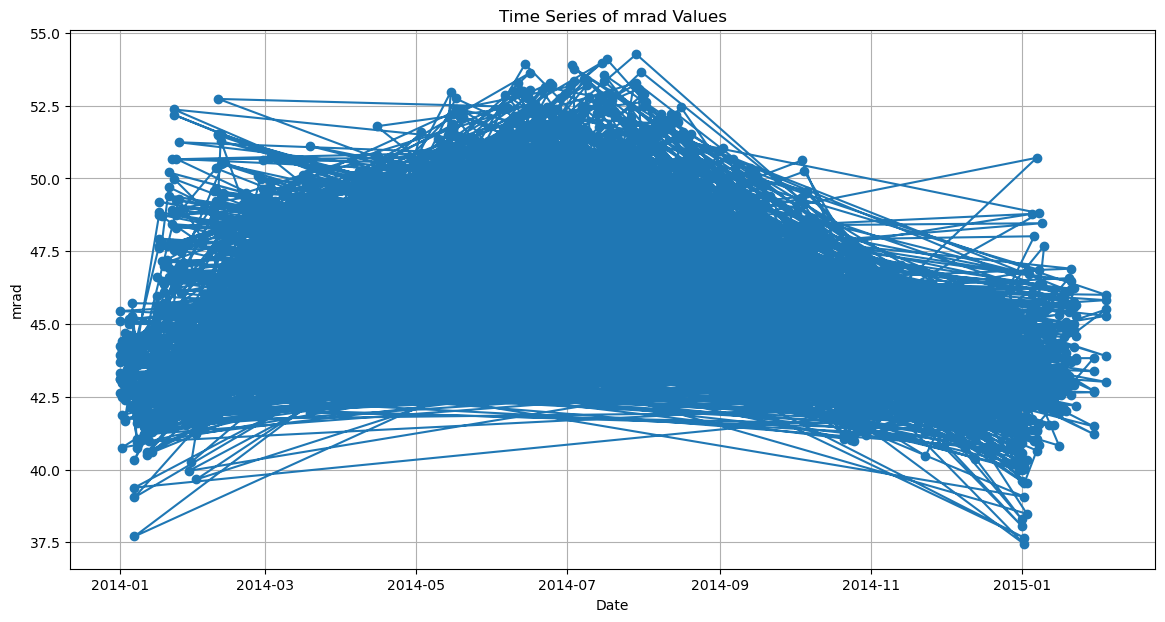

count    3420.000000
mean       46.036399
std         2.822010
min        37.433883
25%        43.863050
50%        45.677683
75%        48.099653
max        54.268950
Name: mrad, dtype: float64

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data with the header
file_path = '/Users/rabia/Downloads/grid9_rad0.txt'
data = pd.read_csv(file_path, delimiter='\s+', header=0)  # Here's the change: header=0 instead of header=None
data.head()

# Now convert the 'd' column to datetime for proper time series analysis
data['d'] = pd.to_datetime(data['d'])

# Plot the time series of 'mrad'
plt.figure(figsize=(14, 7))
plt.plot(data['d'], data['mrad'], marker='o', linestyle='-')
plt.title('Time Series of mrad Values')
plt.xlabel('Date')
plt.ylabel('mrad')
plt.grid(True)
plt.show()

# Basic statistics
mrad_stats = data['mrad'].describe()
mrad_stats

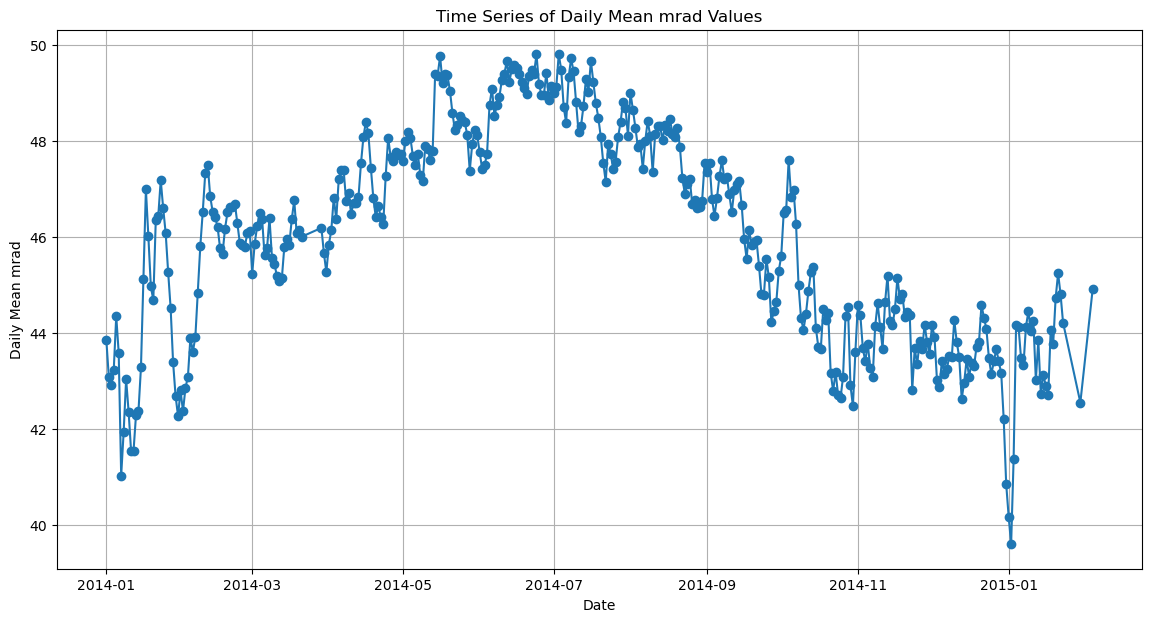

count    383.000000
mean      46.017909
std        2.201497
min       39.589857
25%       44.145221
50%       46.264924
75%       47.862494
max       49.811474
Name: mrad, dtype: float64


In [2]:
# Calculate the daily mean 'mrad' for the entire 3x3 grid to use as your time series data.
daily_mean_mrad = data.groupby('d')['mrad'].mean().reset_index()

# Plot the time series of the daily mean 'mrad'
plt.figure(figsize=(14, 7))
plt.plot(daily_mean_mrad['d'], daily_mean_mrad['mrad'], marker='o', linestyle='-')
plt.title('Time Series of Daily Mean mrad Values')
plt.xlabel('Date')
plt.ylabel('Daily Mean mrad')
plt.grid(True)
plt.show()

# Basic statistics of the daily mean 'mrad'
daily_mean_mrad_stats = daily_mean_mrad['mrad'].describe()
print(daily_mean_mrad_stats)

In [3]:
# Create the training set from the year 2014
train_data = daily_mean_mrad[daily_mean_mrad['d'].dt.year == 2014]

# Create the test set from January 2015
test_data = daily_mean_mrad[(daily_mean_mrad['d'].dt.year == 2015) & (daily_mean_mrad['d'].dt.month == 1)]

# Check the info of the sets
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, 0 to 357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   d       358 non-null    datetime64[ns]
 1   mrad    358 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.4 KB
<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 358 to 381
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   d       24 non-null     datetime64[ns]
 1   mrad    24 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 576.0 bytes


Test RMSE: 2.619


/var/folders/1n/8p7w4sl96l78pkg4qqxcght00000gn/T/ipykernel_8201/2197565729.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['forecast'] = forecast_series.values


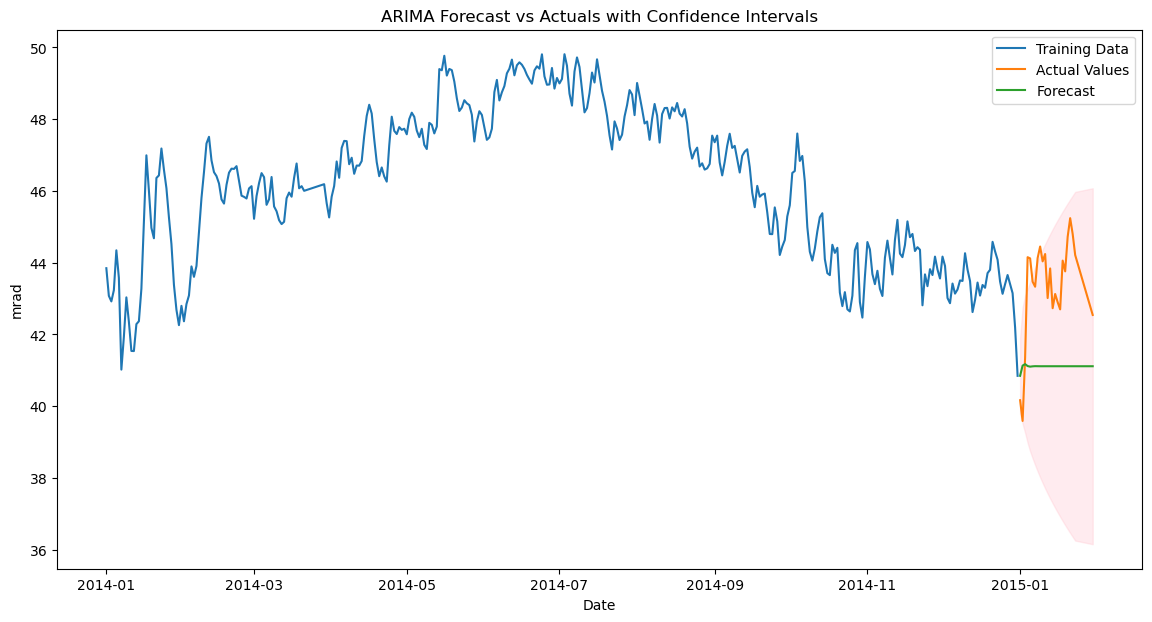

/var/folders/1n/8p7w4sl96l78pkg4qqxcght00000gn/T/ipykernel_8201/2197565729.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'forecast_lower'] = confidence_intervals['lower mrad']
/var/folders/1n/8p7w4sl96l78pkg4qqxcght00000gn/T/ipykernel_8201/2197565729.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'forecast_upper'] = confidence_intervals['upper mrad']


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
# import arima
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model
# Placeholders for actuual parameters
# Note: This often requires some experimentation.
p, d, q = 2, 1, 0  # Example values for ARIMA parameters; adjust based on the data
arima_model = ARIMA(train_data['mrad'], order=(p, d, q))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.get_forecast(len(test_data))
forecast_series = arima_forecast.predicted_mean
confidence_intervals = arima_forecast.conf_int()

# Compare forecast against actual values
test_data['forecast'] = forecast_series.values

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_data['mrad'], test_data['forecast']))
print('Test RMSE: %.3f' % rmse)

# Enhance the plot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(train_data['d'], train_data['mrad'], label='Training Data')
plt.plot(test_data['d'], test_data['mrad'], label='Actual Values')
plt.plot(test_data['d'], test_data['forecast'], label='Forecast')

# Confidence intervals are usually plotted as a shaded area around the forecast
plt.fill_between(test_data['d'], 
                 confidence_intervals['lower mrad'], 
                 confidence_intervals['upper mrad'], 
                 color='pink', alpha=0.3)

plt.title('ARIMA Forecast vs Actuals with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('mrad')
plt.legend()
plt.show()

test_data.loc[:, 'forecast'] = forecast_series.values
test_data.loc[:, 'forecast_lower'] = confidence_intervals['lower mrad']
test_data.loc[:, 'forecast_upper'] = confidence_intervals['upper mrad']


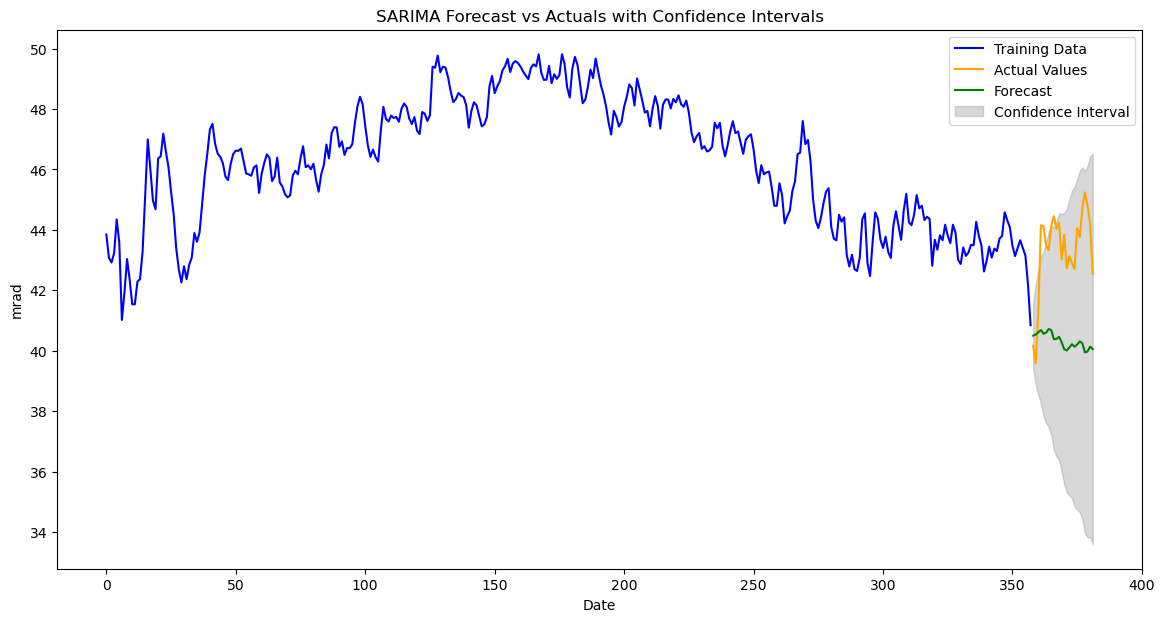

Test RMSE: 3.35


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Placeholder for actual parameters
p, d, q = 2,1,0
P, D, Q, s = 1, 1, 1, 12

sarima_model = SARIMAX(train_data['mrad'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# Make forecast
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the forecast with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['mrad'], label='Training Data', color='blue')  # Ensure index is datetime
plt.plot(test_data.index, test_data['mrad'], label='Actual Values', color='orange')  # Ensure index is datetime
plt.plot(test_data.index, forecast_mean, label='Forecast', color='green')  # Ensure index is datetime
plt.fill_between(test_data.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='grey', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Forecast vs Actuals with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('mrad')
plt.legend()
plt.show()

# Calculate RMSE for the forecast
rmse = sqrt(mean_squared_error(test_data['mrad'], forecast_mean))
print(f'Test RMSE: {rmse:.2f}')


In [6]:
# !pip install torch torchvision torch-geometric

In [7]:
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from datetime import datetime

In [8]:
# Load the data
file_path = '/Users/rabia/Downloads/grid9_rad0.txt'
data = pd.read_csv(file_path, delimiter='\t')

# Parse the dates and sort the dataframe to ensure it is in chronological order
data['d'] = pd.to_datetime(data['d'])
data = data.sort_values(by='d')

# Calculate the daily mean 'mrad' for the entire 3x3 grid to use as your time series data.
daily_mean_mrad = data.groupby('d')['mrad'].mean().reset_index()



In [9]:
# Helper function to extract day of the year from the datetime object
def get_day_of_year(date):
    return date.timetuple().tm_yday

# Updated function to create a graph for each day with 'mrad' and 'day_of_year' as features
def create_graph_for_day(df_for_day, day_of_year):
    node_features = []
    edge_index = []
    
    # Add features for each node (3x3 grid points)
    for index, row in df_for_day.iterrows():
        ilat, ilon, mrad = row['ilat'], row['ilon'], row['mrad']
        feature_vector = torch.tensor([mrad, day_of_year], dtype=torch.float)  # Include 'day_of_year' as a feature
        node_features.append(feature_vector)
    
    # Define the edges based on the 3x3 grid structure
    for ilat in range(3):
        for ilon in range(3):
            node_num = ilat * 3 + ilon
            if ilon < 2:  # Right neighbor
                edge_index.append((node_num, node_num + 1))
            if ilon > 0:  # Left neighbor
                edge_index.append((node_num, node_num - 1))
            if ilat > 0:  # Top neighbor
                edge_index.append((node_num, node_num - 3))
            if ilat < 2:  # Bottom neighbor
                edge_index.append((node_num, node_num + 3))
    
    node_features_tensor = torch.stack(node_features)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor)
    return graph_data

In [10]:
# Create a graph for each day
graphs = []
unique_days = data['d'].dt.floor('d').unique()

for day in unique_days:
    df_for_day = data[data['d'].dt.floor('d') == day]
    day_of_year = get_day_of_year(day)  # Extract day of the year
    graph = create_graph_for_day(df_for_day, day_of_year)
    graphs.append(graph)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class CustomGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomGNN, self).__init__()
        # Define the first GCN layer
        self.conv1 = GCNConv(input_dim, hidden_dim)
        # Define the second GCN layer
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # Apply the first GCN layer with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        # Apply the second GCN layer
        x = self.conv2(x, edge_index)
        return x

Continue working from -- AssertionError: Target labels are missing from the batch. -- add labels

In [12]:
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import r2_score

for graph in graphs:
    #print(graph.x.shape)  # x is the node feature matrix
    #print(graph.edge_index.shape)  # edge_index is the graph connectivity
    if graph.y is None:
        print("Missing target labels for a graph.")
    else:
        print(graph.y.shape)  # y is the target tensor

    if graph.x.size(1) != 2:
        dummy_feature = torch.ones((graph.x.size(0), 1))  # Creating a dummy feature
        graph.x = torch.cat((graph.x, dummy_feature), dim=1)  # Concatenating the dummy feature to existing features

# Print the shapes of x, edge_index, and y for the first few graphs
for i, graph in enumerate(graphs[:5]):  # Adjust the range as needed
    print(f"Graph {i}:")
    print(f"  Node features (x) shape: {graph.x.shape}")
    print(f"  Edge index (edge_index) shape: {graph.edge_index.shape}")
    # Check if y attribute exists before trying to print its shape
    if hasattr(graph, 'y') and graph.y is not None:
        print(f"  Target labels (y) shape: {graph.y.shape}")
    else:
        print("  Target labels (y): Missing")
    print("---")

# Split graphs into training and validation sets
train_graphs, val_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)

input_dim = 2  # Assuming each node has 2 features (e.g., 'mrad' value and 'day_of_year')
hidden_dim = 16  # Example: size of the hidden layer
output_dim = 1  # Assuming we're predicting a single value per node
num_epochs = 100  # Example: number of training epochs

# Instantiate the model, loss function, and optimizer
model = CustomGNN(input_dim, hidden_dim, output_dim)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

def early_stopping(val_loss, best_val_loss, patience_counter, patience=10):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter > patience:
        print("Early stopping triggered")
        return True, best_val_loss, patience_counter
    else:
        return False, best_val_loss, patience_counter
    
best_val_loss = float('inf')
patience_counter = 0

# Updated training and validation function
def train_and_validate(num_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, best_val_loss, patience_counter):
   
    global best_model_state
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch in train_loader:
            # print(batch.x.shape)
            assert batch.y is not None, "Target labels are missing from the batch."
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            print('Output shape:', out.shape if out is not None else None)
            print('Target shape:', batch.y.shape if batch.y is not None else None)
   
            # Assume batch.y is the target tensor for the graphs
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()  # Update learning rate
        
        # Validation phase
        model.eval()
        val_losses = []
        y_true, y_pred = [], []
        for batch in val_loader:
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            val_losses.append(loss.item())
            y_true.extend(batch.y.tolist())
            y_pred.extend(out.tolist())
        
        avg_val_loss = sum(val_losses) / len(val_losses)
        val_r2 = r2_score(y_true, y_pred)
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss}, Val R2: {val_r2}')

        # Checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        # Early Stopping
        stop, best_val_loss, patience_counter = early_stopping(avg_val_loss, best_val_loss, patience_counter)
        if stop:
            break
    return best_model_state

best_model_state = train_and_validate(num_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, best_val_loss, patience_counter)
# Save the best model state
torch.save(best_model_state, 'best_gnn_model.pth')

Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target labels for a graph.
Missing target label

/Users/rabia/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


AssertionError: Target labels are missing from the batch.